# Projet searchy indexation et recherche de documents
Ayoub SBAI - Sohaib ATTAIKI

## 1. Traitement linguistique

**Collection CACM:**
 * Nombre de tokens : 413569
 * Taille du vocabulaire : 5961

pour la moitié de la collection, on trouve que le nombre de tokens est: 152419, la taille du vocabulaire est : 3475.  donc on peut déduire que les paramètres k et b de la loi de Heap sont égaux à **k = 5,48** et  **b = 0.5406**.  
Pour une collection de 1 millions de tokens, on estime que la taille du vocabulaire est : **9602**.

**Collection Stanford:**
 * Nombre de tokens : 10254299
 * Taille du vocabulaire : 268191

pour un dossier de la collection, on trouve que le nombre de tokens est : 1112154. la taille du vocabulaire est : 51349.  
donc on peut déduire que les paramètres k et b de la loi de Heap sont égaux à **k = 1.72** et **b = 0.74**  
Pour une collection de 1 millions de tokens, on estime que la taille du vocabulaire est : **47373**

### Loi de zipf
On trace la courbe rang - frequence

In [1]:
import words
import math
import matplotlib.pyplot as plt
import os.path
import pylab
from scipy import interpolate

from Index import Index
pylab.rcParams['figure.figsize'] = (16, 10)


def plot_zipf(index):
    frequencies = []
    for term in index.inversed_index:
        frequencies.append(sum(index.inversed_index[term].values()))
    frequencies.sort(reverse=True)
    
    plt.xlabel('rang')
    plt.ylabel('fréquence')
    plt.plot([x for x in range(1, len(frequencies) + 1)], frequencies)
    plt.show()

    plt.xlabel('log rang')
    plt.ylabel('log fréquence')
    plt.plot([math.log(x) for x in range(1, len(frequencies) + 1)], [math.log(frequency) for frequency in frequencies])
    plt.show()

**Collection CACM**

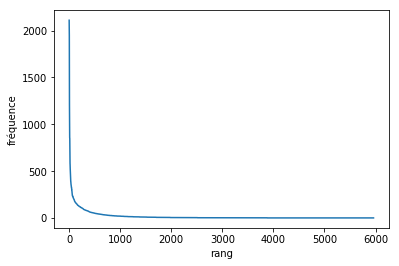

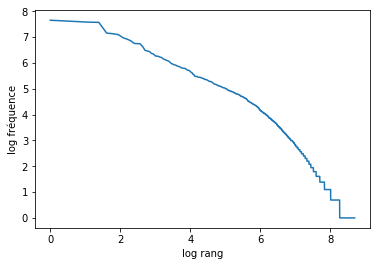

In [2]:
collection_path = os.path.join("data", "CACM", "cacm.all")
plot_zipf(Index.index_cacm_file(collection_path, verbose=False))

**Collection Stanford**

In [3]:
collection_path = os.path.join("dumps", "pa1-data", "pa1-data")
plot_zipf(Index.index_directory(collection_path, verbose=False))

AttributeError: 'NoneType' object has no attribute 'inversed_index'

## 2. Implémentation du moteur de recherche

Notre moteur de recherche s'appelle [searchy](https://github.com/souhaibattaiki/searchy), il permet d'indexer une collection de documents. Il prend en entrée soit le chemin vers un dossier contenant des documents à indexer soit un fichier au format CACM.

### Installation et usage
*Searchy* tourne sous Python 3. Il faut installer les dépendences avec les commandes suivantes:
``` 
pip3 install -r requirements.txt
python3 -c "import nltk; nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet');"
```
Ci-dessous le message d'aide pour l'outil:
```
usage: searchy.py [-h] [-q QUERY] [-m {bool,vect}]
                  [-n {cos,dice,jaccard,overlap}] [-t THRESHOLD]
                  [-w {f,tfidf,nf}] [-s] [-f] [--no-cache]
                  collection

Builds a search engine on a collection of documents

positional arguments:
  collection            Path to collection file (CACM format), directory or
                        url to zip

optional arguments:
  -h, --help            show this help message and exit
  -q QUERY, --query QUERY
                        Execute a search query
  -m {bool,vect}, --model {bool,vect}
                        Search engine model
  -n {cos,dice,jaccard,overlap}, --norm {cos,dice,jaccard,overlap}
                        Vectorial search norm
  -t THRESHOLD, --threshold THRESHOLD
                        Vectorial search norm threshold
  -w {f,tfidf,nf}, --weighting {f,tfidf,nf}
                        Vectorial weighting method
  -s, --silent          Disable verbose mode
  -f, --force           Force re-indexing overwrite cache
  --no-cache            Disable disk cache
```

### Indexation
Nous avons implémenter l'algorithme d'indexation BSBI, notre index est un dictionnaire dont les clés sont les terms de la collections et les valeurs sont des dictionnaires de documents id avec la fréquence d'appartion comme valeur.  
Nous ne stockons pas les vecteurs documents pondérés dans l'indexe afin de réduire sa taille (15 Mb seulement pour la collection stanford).  
**Système de cache** L'indexation d'une collection peut-être cachée (comportement par défault). Ceci permet de ne pas recalculer ce qui a déjà été calculé pour une collection donnée. le temps d'indexation est considérablement réduit.  
**Map Reduce** Quand on indexe un dossier (le cas de stanford), *searchy* va procéder par blocs que sous-dossiers. On parcours par réccurence tous les sous dossiers du path d'entré et on indexe tous les fichiers dedans. Une fois l'indexe construit pour un sous dossier, on le merge à notre indexe principale. Ce système permet de réduire la taille de données chargés en la memoire au même temps. 

### Modèle Booléen
Pour activer le modèle booléen sur *searchy* on utilise l'option `-m bool`. Les requêtes sont formées à partir de terms et d'opérateurs **&** (et), **|** (ou), **~** (non) et de parenthèses. Un exemple de requête est:
```
programming & ( language | computer ) & ~mean
```
Les espaces sont optionnels.  
**Evaluation des requêtes booléenes** L'évalution se fait en construisant l'arbre d'execution de l'expression booléenne, en intrerprétant les opérateurs par les opérateurs sur l'ensemble de documents de la collection (union pour ou, intersection pour et, etc...)
 
### Modèle Vectoriel
Le modèle vectoriel est le modèle par défault de *searchy*. On peut choisir la mesure de similaritée (norme) et la méthode de pondération avec les options `-n NORM` et `-w WEIGHTING`.  
 * les normes disponibles sont:  **cos**, **dice**, **jaccard** et **overlap**
 * Les méthodes de pondérations disponibles sont: **f** (fréquence brute), **tfidf**, **nf** (fréquence normalisée)

### Tests unitaires
Des tests unitaires ont été mis en place et s'executes avec la commande suivante:
```
python -m unittest -v tests/*.py
```

## 3. Evaluation CACM

### Données d'evaluation

In [4]:
# project
from Index import Index
from Document import Document
from search.vectorial import VectorialSearchEngine
from search.calc import WEIGHTINGS, NORMS

collection_path = os.path.join("data", "CACM", "cacm.all")
querls_path =  os.path.join("data", "CACM", "qrels.text")
queries_path =  os.path.join("data", "CACM", "query.text")

# Parse queries as CACM document format
queries = Document.parse_cacm(queries_path)

# Parse qrels.text file
querls = {}
with open(querls_path, 'r') as querls_file:
    for line in querls_file:
        query_id, res, _, _ = list(map(int, line.split()))
        if query_id not in querls:
            querls[query_id] = set()
        querls[query_id].add(res)

### Performance

#### Indexation

In [5]:
index = Index.index_cacm_file(collection_path, use_cache=False)

Loading data/CACM/cacm.all
Loaded data/CACM/cacm.all
  documents 	 3204
  tokens 	 113754
  terms 	 5961
time: 27.01 s     memory: 0.42 mb


In [6]:
Index.index_directory(os.path.join("dumps", "pa1-data", "pa1-data"))

Loading dumps/pa1-data/pa1-data


AttributeError: 'NoneType' object has no attribute 'inversed_index'

#### Recherche

In [7]:
from search.vectorial import VectorialSearchEngine
from search.bool import BooleanSearchEngine
from statistics import mean
from time import time
from random import sample, randint


engine = VectorialSearchEngine(index, weighting="tfidf", norm="cos", threshold=0.6)
query_time = []
ROUNDS = 500
for _ in range(ROUNDS):
    query = " ".join(sample(index.inversed_index.keys(), randint(2, 20)))
    start = time()
    engine.search(query, top=10)
    end = time()
    query_time.append((end - start)*1000)

print("Vectorial model query time (ms)")
print("max:  {:.4f}".format(max(query_time)))
print("min:  {:.4f}".format(min(query_time)))
print("mean: {:.4f}".format(mean(query_time)))

engine = BooleanSearchEngine(index)
query_time = []
for _ in range(ROUNDS):
    query = "&".join(sample(index.inversed_index.keys(), randint(2, 5)))
    query += "&(" + "|".join(sample(index.inversed_index.keys(), randint(2, 5))) + ")"
    start = time()
    engine.search(query)
    end = time()
    query_time.append((end - start)*1000)

print("Boolean model query time (ms)")
print("max:  {:.2f}".format(max(query_time)))
print("min:  {:.2f}".format(min(query_time)))
print("mean: {:.2f}".format(mean(query_time)))

Vectorial model query time (ms)
max:  88.9287
min:  0.9384
mean: 9.1919
Boolean model query time (ms)
max:  4.85
min:  1.05
mean: 1.98


### Courbe Rappel Précision

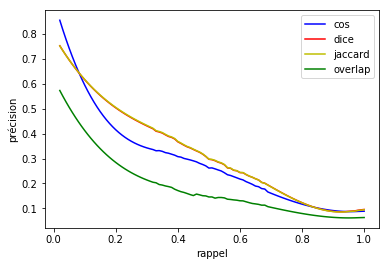

In [13]:
from scipy.signal import savgol_filter

precision = {}
recall = {}
precision_p = {}
recall_p = {}
r_precision = {}
RESOLUTION = 1000

X, Y = {}, {}
for norm in NORMS:
    engine = VectorialSearchEngine(index, weighting="tfidf", norm=norm, threshold=0.0)
    precision[norm] = {}
    recall[norm] = {}
    r_precision[norm] = []

    for query in queries:
        query_str = query.content.replace('.W\n', '')
        query_str = query_str.replace('.K\n', '')
        if query.get_id() not in querls:
            continue
        precision[norm][query.get_id()] = {}
        recall[norm][query.get_id()] = []
        expected = querls[query.get_id()]
        results, total_returned = engine.search(query_str, top=-1)
        results = [doc_id for _, doc_id in results]
        recal = 0
        res = results[:len(expected)]
        r_precision[norm].append(sum([1 for doc_id in res if doc_id in expected]) / len(res))
        for top in range(1, RESOLUTION+1):
            res = results[:top]
            temp = round(sum([1 for doc_id in res if doc_id in expected]) / len(expected), 2)
            if temp > recal:
                recal = temp
                recall[norm][query.get_id()].append(recal)
                precision[norm][query.get_id()][recal] = sum([1 for doc_id in res if doc_id in expected]) / len(res)
        for i in range(len(recall[norm][query.get_id()])):
            recal = recall[norm][query.get_id()][i]
            precision[norm][query.get_id()][recal] = max([precision[norm][query.get_id()][recall[norm][query.get_id()][j]] for j in range(i, len(recall[norm][query.get_id()]))])
    r_precision[norm] = mean(r_precision[norm])
    recall_p[norm] = []
    precision_p[norm] = []
    for query in queries:
        if query.get_id() in querls:
            recall_p[norm] = list(set(recall[norm][query.get_id()]) | set(recall_p[norm]))
    recall_p[norm].sort()
    for recal in recall_p[norm]:
        m = []
        for query in queries :
            if query.get_id() in querls and recal in precision[norm][query.get_id()].keys():
                m.append(precision[norm][query.get_id()][recal])
        precision_p[norm].append(mean(m))
    precision_p[norm] = savgol_filter(precision_p[norm], 61, 3)
     
colors = {
    'cos': 'b',
    'dice': 'r',
    'jaccard': 'y',
    'overlap': 'g'
}
for norm in NORMS:
    plt.plot(recall_p[norm], precision_p[norm], colors[norm], label=norm)

plt.legend()
plt.ylabel('précision')
plt.xlabel('rappel')
plt.show()

### R-précision

In [10]:
from tabulate import tabulate
r_mesure = [[round(r_precision[norm],3) for norm in NORMS]]
print(tabulate(r_mesure, headers=['cos', 'dice', 'jaccard', 'overlap']))

  cos    dice    jaccard    overlap
-----  ------  ---------  ---------
0.274   0.299      0.301      0.127


### E-mesure et F-mesure

norm           min       max      mean
-------  ---------  --------  --------
cos      0.0200107  0.3406    0.197743
dice     0.0200137  0.384035  0.21563
jaccard  0.0200137  0.385021  0.215758
overlap  0.0200235  0.246699  0.135543


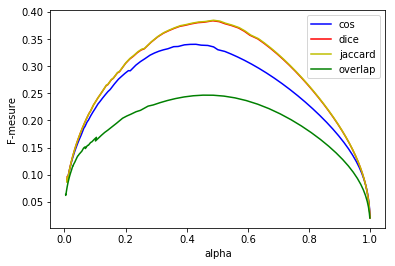

In [14]:
def Emeasure(P, R):
    B = P / R
    return 1 - ((B**2+1)*P*R)/(P*(B**2)+R)

def alpha(P, R):
    B = P / R
    return 1 / (B**2 + 1)

def Fmeasure(P, R):
    return 1 - Emeasure(P, R)

table = []
for norm in NORMS:
    PR = [(recall_p[norm][i], precision_p[norm][i]) for i in range(len(recall_p[norm]))]
    F = [Fmeasure(P, R) for P, R in PR]
    A = [alpha(P, R) for P, R in PR]
    table.append([norm, min(F), max(F), mean(F)])
    plt.plot(A, F, colors[norm], label=norm)

print(tabulate(table, headers=['norm', 'min', 'max', 'mean']))
plt.legend()
plt.ylabel('F-mesure')
plt.xlabel('alpha')
plt.show()

### Mean average precision

In [27]:
from statistics import StatisticsError

mean_avg = {} 
for norm in NORMS:
    engine = VectorialSearchEngine(index, weighting="tfidf", norm=norm, threshold=0.0)
    mean_avg[norm] = {}
    for query in queries:
        query_str = query.content.replace('.W\n', '')
        query_str = query_str.replace('.K\n', '')
        if query.get_id() not in querls:
            continue
        mean_avg[norm][query.get_id()] = []
        expected = querls[query.get_id()]
        results, total_returned = engine.search(query_str, top=-1)
        results = [doc_id for _, doc_id in results]
        for i, doc_id in enumerate(results):
            res = results[:i+1]
            if doc_id in expected:
                recall = sum([1 for doc_id in res if doc_id in expected]) / len(expected)
                precision = sum([1 for doc_id in res if doc_id in expected]) / len(res)
                mean_avg[norm][query.get_id()].append(precision)
                if recall >= 1:
                    break
        if query.get_id() == 2 and norm == 'cos':
            print(results)
        try:
            mean_avg[norm][query.get_id()] = mean(mean_avg[norm][query.get_id()])
        except StatisticsError:
            mean_avg[norm][query.get_id()] = 0
    mean_avg[norm] = mean([mean_avg[norm][query.get_id()] for query in queries if query.get_id() in mean_avg[norm]])
headers = list(sorted(NORMS.keys()))
table = [['mean avg'] + [mean_avg[norm] for norm in headers]]
print(tabulate(table, headers=headers))

[397, 1046, 971, 1145, 1345, 1939, 2483, 2850, 3080, 2317, 236, 598, 1155, 1272, 1278, 1333, 1665, 1938, 2051, 2229, 2304, 2572, 2628, 2688, 2874, 3076, 3181, 1651, 136, 248, 254, 322, 356, 435, 462, 492, 531, 616, 724, 740, 944, 964, 1014, 1026, 1099, 1364, 1381, 1383, 1397, 1440, 1472, 1595, 1601, 1604, 1616, 1623, 1637, 1664, 1743, 1768, 1770, 1867, 1951, 2016, 2106, 2145, 2254, 2305, 2306, 2400, 2402, 2665, 2684, 2699, 2737, 2804, 2808, 2866, 3148, 282, 321, 597, 728, 847, 942, 1117, 1161, 1168, 1183, 1214, 1215, 1264, 1305, 1315, 1334, 1348, 1391, 1403, 1424, 1427, 1439, 1464, 1468, 1469, 1486, 1498, 1503, 1523, 1542, 1549, 1564, 1591, 1625, 1671, 1676, 1680, 1705, 1741, 1811, 1854, 1861, 1926, 2002, 2092, 2096, 2217, 2233, 2356, 2383, 2439, 2456, 2471, 2519, 2645, 2812, 2912, 2937, 2939, 2943, 3005, 3077, 3127, 3160, 3189, 3199, 3201, 3202, 3204]
              cos      dice    jaccard    overlap
--------  -------  --------  ---------  ---------
mean avg  0.27697  0.314527   0.317